In [1]:
import gzip
import json
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import networkx as nx
import torch
from torch import tensor
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from partitioning import KL

In [2]:
with gzip.open('../data/xbar/1/xbar.json.gz','rb') as f:
    design = json.loads(f.read().decode('utf-8'))
    
instances = pd.DataFrame(design['instances'])
nets = pd.DataFrame(design['nets'])

conn=np.load('../data/xbar/1/xbar_connectivity.npz')
A = coo_matrix((conn['data'], (conn['row'], conn['col'])), shape=conn['shape'])
A = A.__mul__(A.T)

def buildBST(array,start=0,finish=-1):
    if finish<0:
        finish = len(array)
    mid = (start + finish) // 2
    if mid-start==1:
        ltl=start
    else:
        ltl=buildBST(array,start,mid)
    
    if finish-mid==1:
        gtl=mid
    else:
        gtl=buildBST(array,mid,finish)
        
    return((array[mid],ltl,gtl))

congestion_data = np.load('../data/xbar/1/xbar_congestion.npz')
xbst=buildBST(congestion_data['xBoundaryList'])
ybst=buildBST(congestion_data['yBoundaryList'])
demand = np.zeros(shape = [instances.shape[0],])


def getGRCIndex(x,y,xbst,ybst):
    while (type(xbst)==tuple):
        if x < xbst[0]:
            xbst=xbst[1]
        else:
            xbst=xbst[2]
            
    while (type(ybst)==tuple):
        if y < ybst[0]:
            ybst=ybst[1]
        else:
            ybst=ybst[2]
            
    return ybst, xbst


for k in range(instances.shape[0]):
    #print(k)
    xloc = instances.iloc[k]['xloc']; yloc = instances.iloc[k]['yloc']
    i,j=getGRCIndex(xloc,yloc,xbst,ybst)
    d = 0 
    for l in list(congestion_data['layerList']): 
        lyr=list(congestion_data['layerList']).index(l)
        d += congestion_data['demand'][lyr][i][j]
    demand[k] = d
        
instances['routing_demand'] = demand

In [3]:
instances

,name,id,xloc,yloc,cell,orient,routing_demand
0,clk_gate_out_reg/latch,0,41984,44544,23,0,20.0
1,clk_gate_out_reg_0/latch,1,41984,47616,23,6,23.0
2,clk_gate_out_reg_1/latch,2,44160,44544,23,0,23.0
3,clk_gate_out_reg_2/latch,3,44160,47616,23,0,22.0
4,clk_gate_out_reg_3/latch,4,46336,47616,23,0,21.0
...,...,...,...,...,...,...,...
3947,U4123,3947,21888,53760,42,4,31.0
3948,U4125,3948,33664,66048,42,0,30.0
3949,U4128,3949,23296,66048,34,0,27.0
3950,ZCTSBUF_205_132,3950,40576,44544,11,0,28.0


In [4]:
G = nx.from_scipy_sparse_matrix(A)

/var/folders/rg/mvn599q51g5_76hcm5b9cjgw0000gn/T/ipykernel_90989/4037532936.py:1: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(A)


In [5]:
partitions = KL(G, 1)
partitions

In [6]:
p1, p2 = partitions
p1, p2

(<networkx.classes.graph.Graph at 0x17a60c990>,
 <networkx.classes.graph.Graph at 0x105b42b50>)

In [7]:
def compute_cross_edge_weight(G, a, b):
    # Does not take in edge weights
    return len(G.edges) - (len(a.edges) + len(b.edges))

In [8]:
compute_cross_edge_weight(G, p1, p2)

8164

NodeView((0, 1))

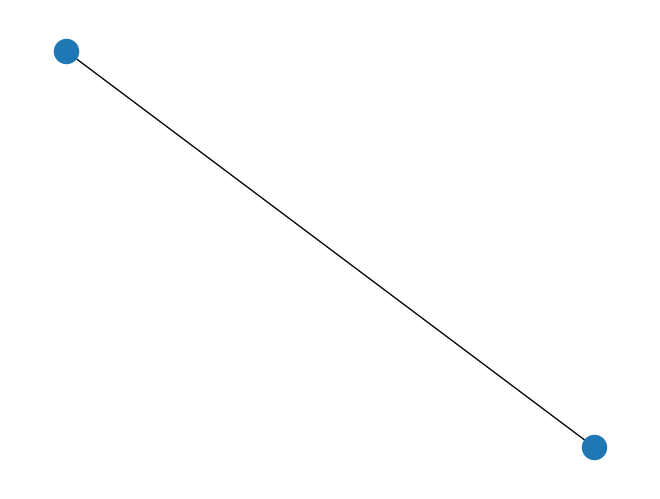

In [17]:
def super_graph(G, partitions):
    out = nx.Graph()
    for i in range(len(partitions)):
        for j in range(len(partitions)):
            if i==j or out.has_edge(i, j):
                continue
            out.add_edge(i, j, weight=compute_cross_edge_weight(G, partitions[i], partitions[j]))
    return out

nx.draw(super_graph(G, partitions))
super_graph(G, partitions).nodes